# physik690 - Bachelorarbeit

In [46]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
from enum import Enum
import sqlite3
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (10, 6)

dpi = 300

In [47]:
class Algorithm(Enum):
    Metropolis = 0
    Wolff = 1

class Observable(Enum):
    Energy = 0
    EnergySquare = 1
    Magnetization = 2
    MagnetizationSquare = 3
    SpecificHeat = 4
    MagneticSusceptibility= 5

    def name(self) -> str:
        match self:
            case Observable.Energy:
                return "Energy"
            case Observable.EnergySquare:
                return "Energy squared"
            case Observable.Magnetization:
                return "Magnetization"
            case Observable.MagnetizationSquare:
                return "Magnetization squared"
            case Observable.SpecificHeat:
                return "Specific heat"
            case Observable.MagneticSusceptibility:
                return "Magnetic susceptibility"

    def symbol(self) -> str:
        match self:
            case Observable.Energy:
                return "E"
            case Observable.EnergySquare:
                return "E^2"
            case Observable.Magnetization:
                return "M"
            case Observable.MagnetizationSquare:
                return "M^2"
            case Observable.SpecificHeat:
                return "C_V"
            case Observable.MagneticSusceptibility:
                return "\\chi"

In [48]:
def plot_observable_per_spin(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots()
    for size in pd.read_sql_query(f'SELECT DISTINCT lattice_size FROM configurations WHERE simulation_id = {simulation_id}', con)['lattice_size']:
        data = pd.read_sql_query(f'SELECT temperature, e.mean, e.std_dev FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN estimates e ON e.configuration_id = c.configuration_id AND e.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.lattice_size = \'{size}\' ORDER BY temperature', con)
        ax.errorbar(data['temperature'], data['mean'], yerr=data['std_dev'], label=f'$N = {size} \\times {size}$')

        ax.set_title(f'{observable.name()} per spin for a 2D lattice using the {alg.name} algorithm')
        ax.set_xlabel('Temperature $T / \\frac{J}{k_B}$')
        ax.set_ylabel(f'{observable.name()} per spin ${observable.symbol()}$')

        ax.legend()
    return fig, ax

def get_observable_max(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable) -> pd.DataFrame:
    return pd.read_sql_query(f'SELECT lattice_size, temperature, MAX(mean) FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN estimates e ON e.configuration_id = c.configuration_id AND e.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.temperature BETWEEN 0.8 AND 1.2 AND lattice_size >= 20 GROUP BY c.lattice_size', con)

In [49]:
def plot_observable_integrated_autocorrelation(con: sqlite3.Connection, simulation_id: int, alg: Algorithm, observable: Observable):
    fig, ax = plt.subplots()
    for size in pd.read_sql_query(f'SELECT DISTINCT lattice_size FROM configurations WHERE simulation_id = {simulation_id}', con)['lattice_size']:
        data = pd.read_sql_query(f'SELECT temperature, tau FROM configurations c INNER JOIN metadata m ON c.metadata_id = m.metadata_id AND m.algorithm = {alg.value} INNER JOIN chunks ch ON ch.configuration_id = c.configuration_id AND ch."index" = 1 INNER JOIN results r ON r.chunk_id = ch.chunk_id AND r.type_id = {observable.value} WHERE c.simulation_id = \'{simulation_id}\' AND c.lattice_size = \'{size}\' ORDER BY temperature', con)
        ax.errorbar(data['temperature'], data['tau'], label=f'$N = {size} \\times {size}$')

        ax.set_title(f'{observable.name()} integrated autocorrelation time for a 2D lattice using the {alg.name} algorithm')
        ax.set_xlabel('Temperature $T / \\frac{J}{k_B}$')
        ax.set_ylabel(f'{observable.name()} per spin $\\tau$')

        #ax.set_yscale('log')
        ax.legend()
    return fig, ax

In [50]:
con = sqlite3.connect('output/data.db')
simulation_id = pd.read_sql_query('SELECT simulation_id FROM simulations ORDER BY created_at DESC', con).at[0, 'simulation_id']
print(f'The current simulation id is {simulation_id}')

The current simulation id is 0


# Energy

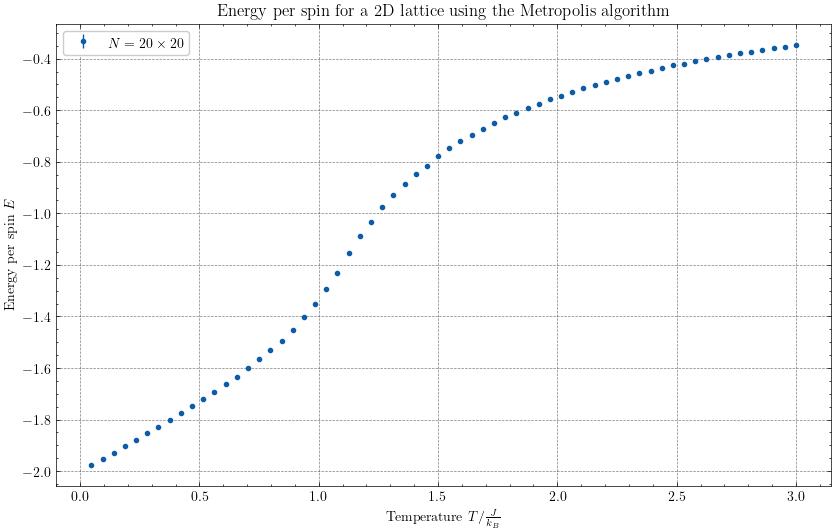

In [51]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.Energy)
fig.savefig('figures/Metropolis/Energy.pdf', dpi=dpi,  bbox_inches='tight')

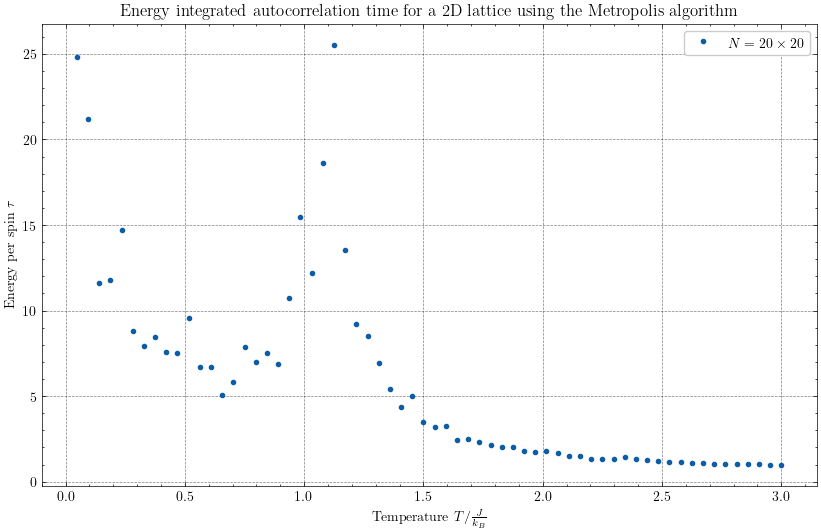

In [52]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.Energy)
fig.savefig('figures/Metropolis/Energy_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

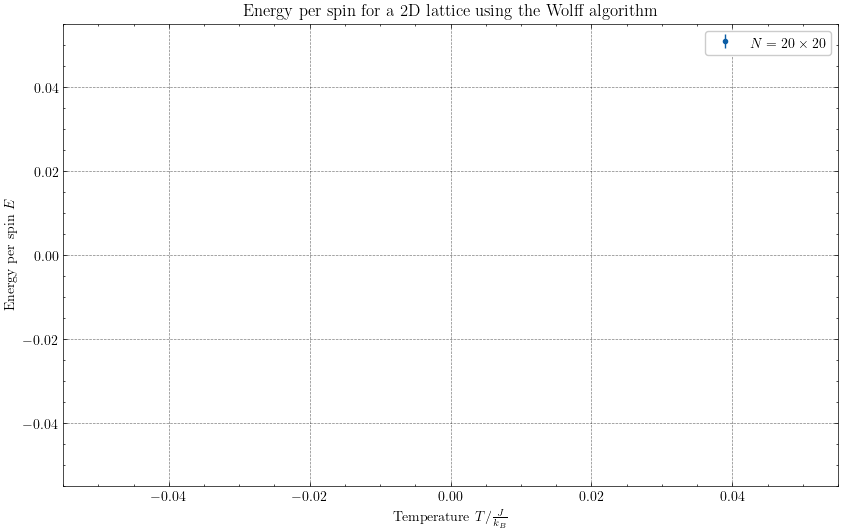

In [53]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.Energy)
fig.savefig('figures/Wolff/Energy.pdf', dpi=dpi,  bbox_inches='tight')

# Energy Square

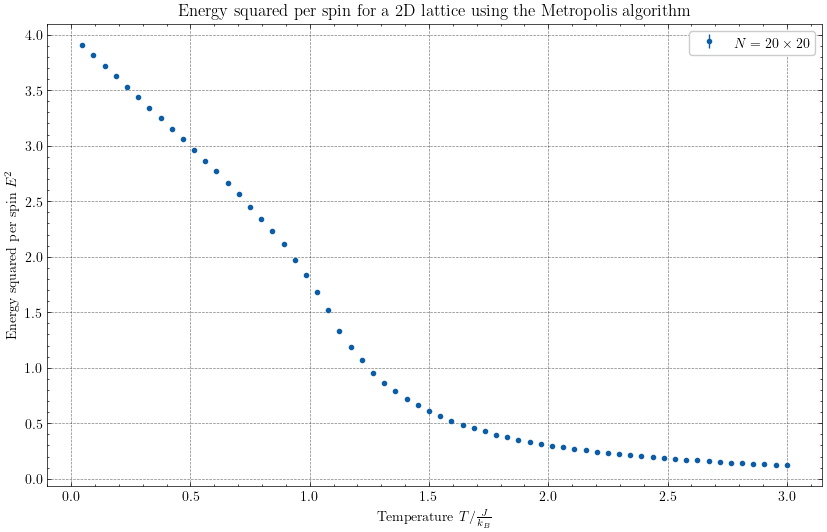

In [54]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.EnergySquare)
fig.savefig('figures/Metropolis/EnergySquare.pdf', dpi=dpi,  bbox_inches='tight')

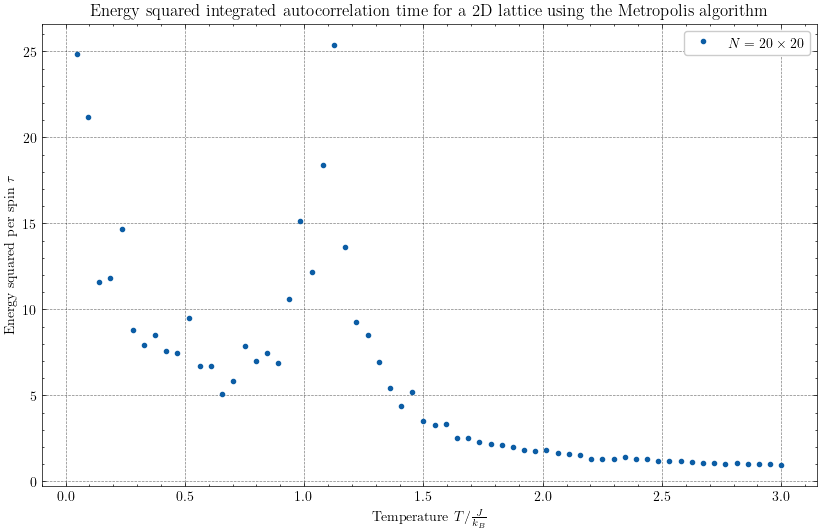

In [55]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.EnergySquare)
fig.savefig('figures/Metropolis/EnergySquare_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

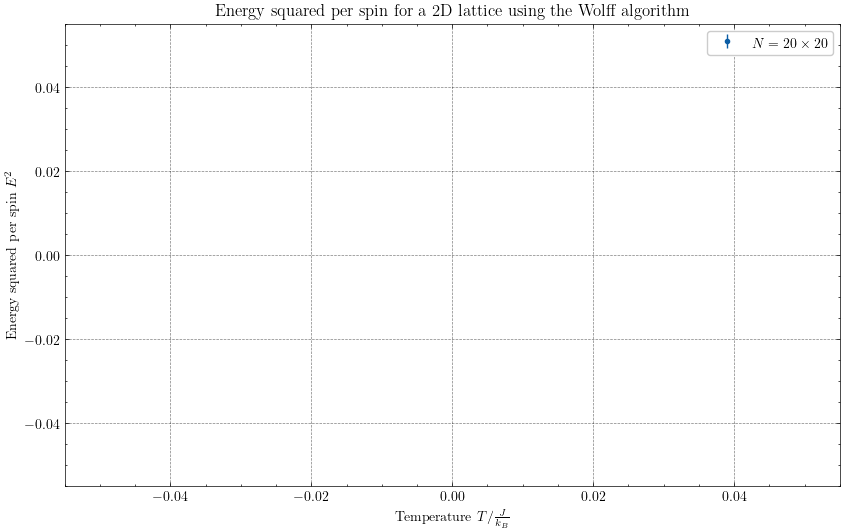

In [56]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.EnergySquare)
fig.savefig('figures/Wolff/EnergySquare.pdf', dpi=dpi,  bbox_inches='tight')

# Specific heat

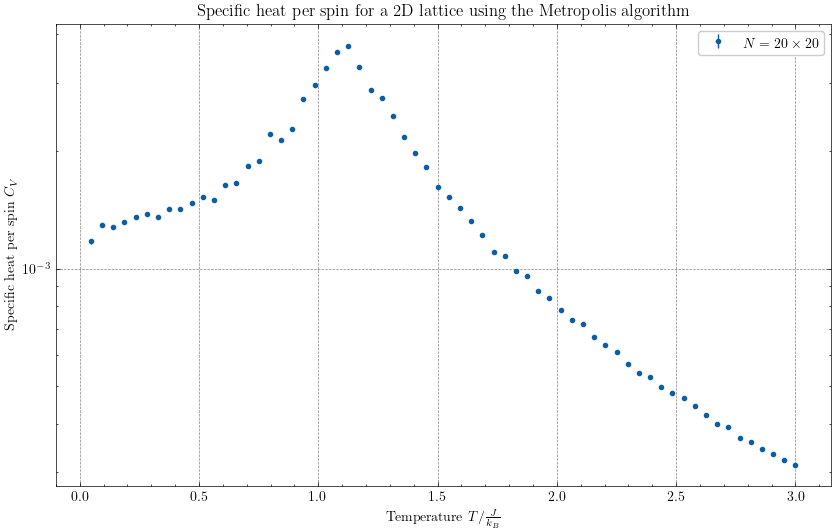

In [57]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.SpecificHeat)
ax.set_yscale('log')
fig.savefig('figures/Metropolis/SpecificHeat.pdf', dpi=dpi,  bbox_inches='tight')

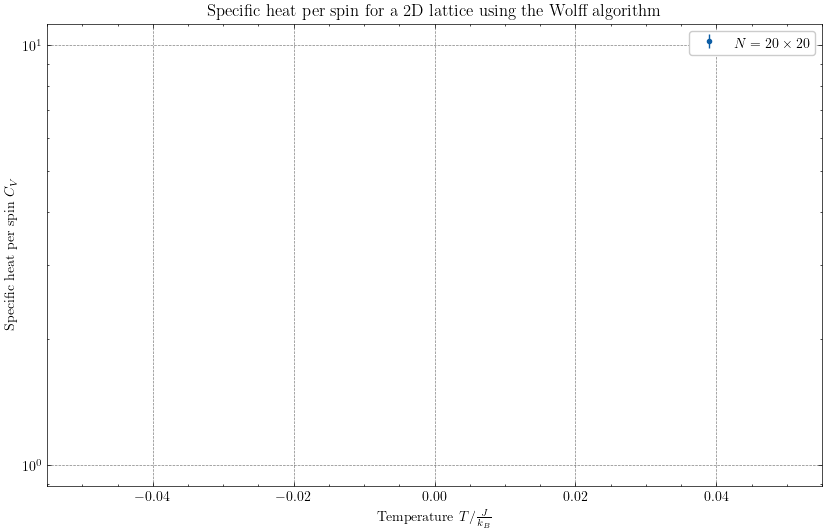

In [58]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.SpecificHeat)
ax.set_yscale('log')
fig.savefig('figures/Wolff/SpecificHeat.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetization

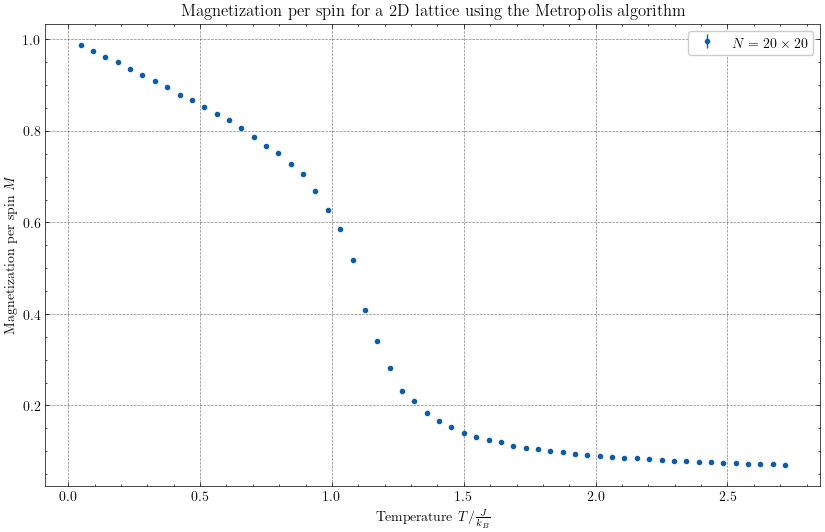

In [59]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.Magnetization)
fig.savefig('figures/Metropolis/Energy.pdf', dpi=dpi,  bbox_inches='tight')

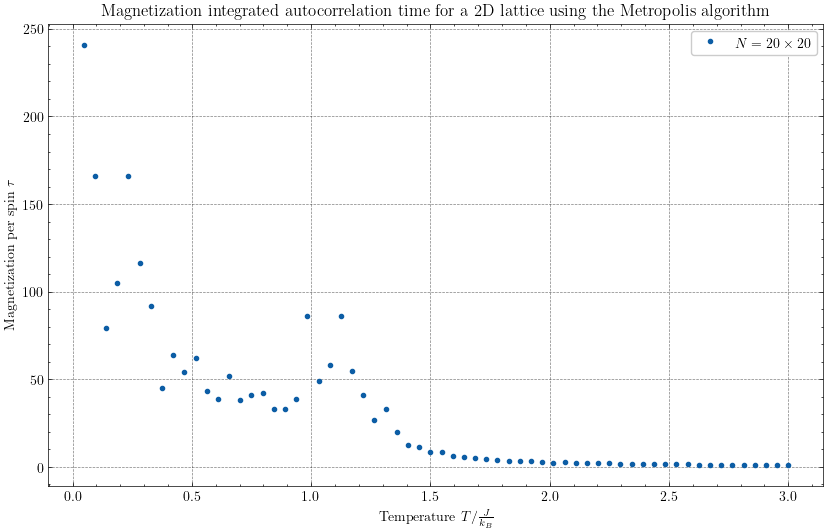

In [60]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.Magnetization)
fig.savefig('figures/Metropolis/Magnetization_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

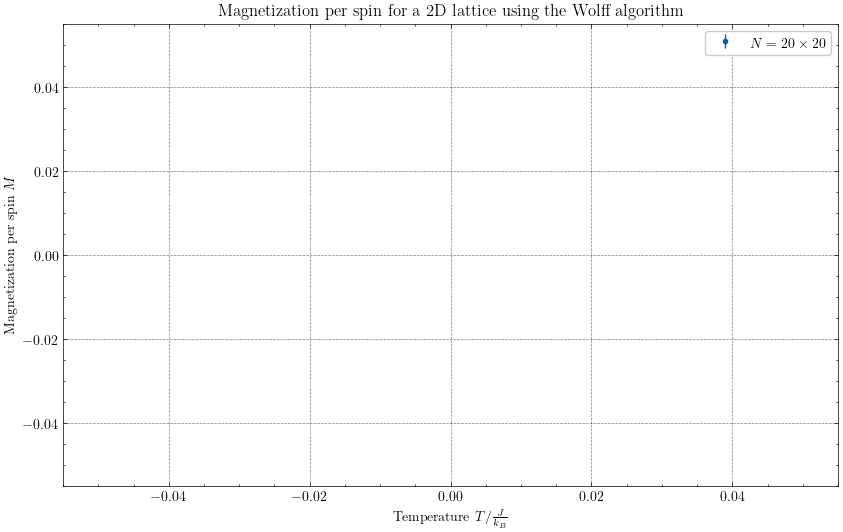

In [61]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.Magnetization)
fig.savefig('figures/Wolff/Magnetization.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetization squared

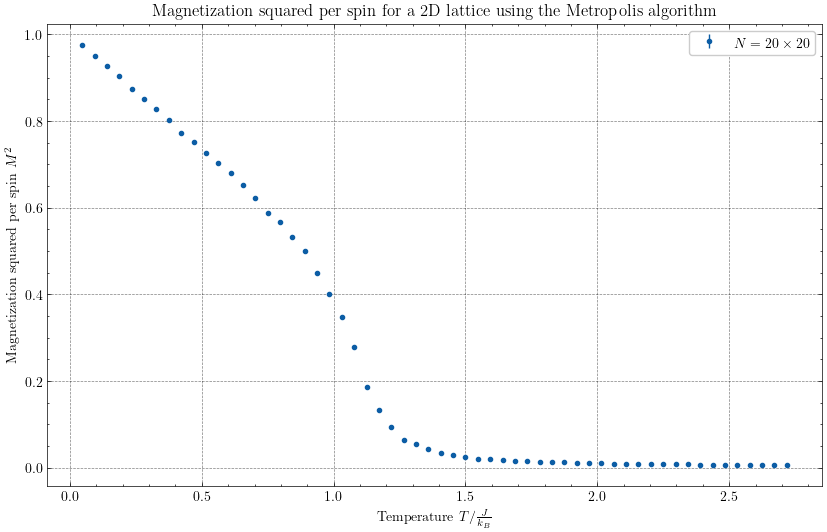

In [62]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.MagnetizationSquare)
fig.savefig('figures/Metropolis/MagnetizationSquare.pdf', dpi=dpi,  bbox_inches='tight')

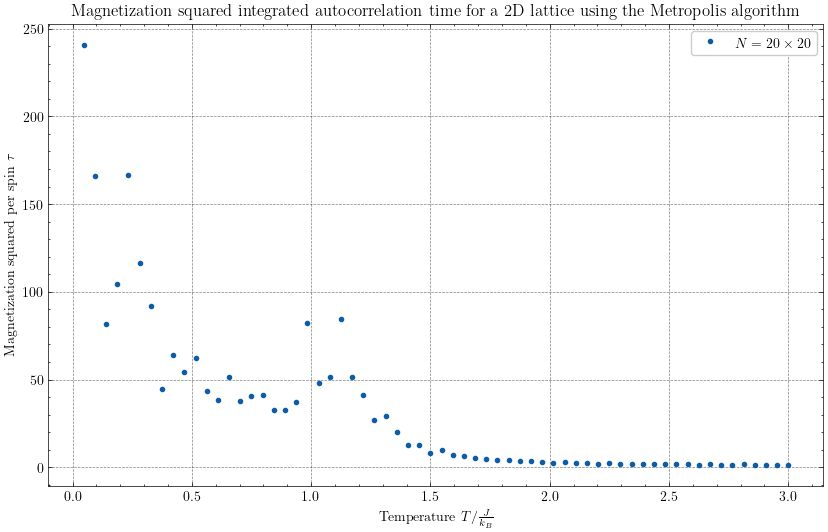

In [63]:
fig, _ = plot_observable_integrated_autocorrelation(con, simulation_id, Algorithm.Metropolis, Observable.MagnetizationSquare)
fig.savefig('figures/Metropolis/MagnetizationSquare_IntegratedAutocorrelation.pdf', dpi=dpi,  bbox_inches='tight')

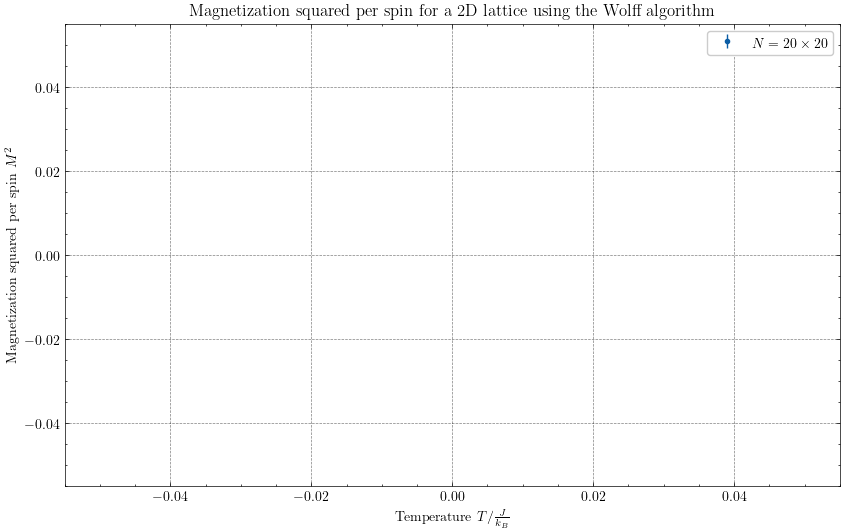

In [64]:
fig, _ = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.MagnetizationSquare)
fig.savefig('figures/Wolff/MagnetizationSquare.pdf', dpi=dpi,  bbox_inches='tight')

# Magnetic Susceptibility

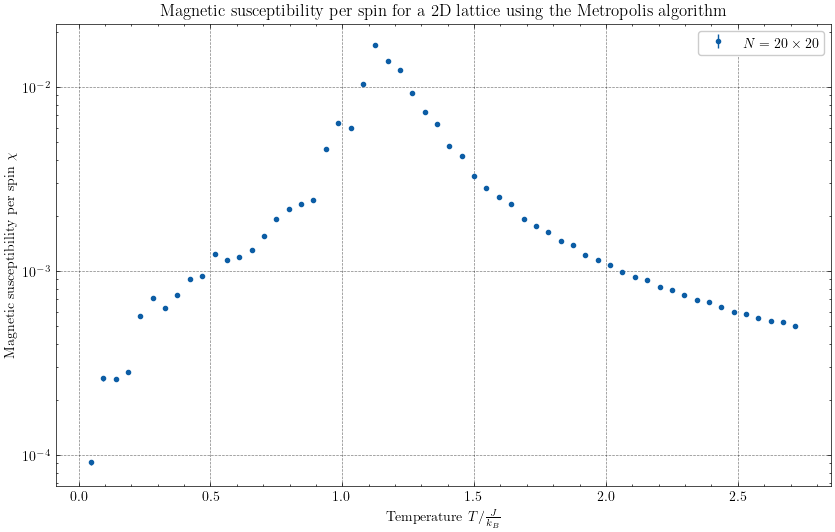

In [65]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Metropolis, Observable.MagneticSusceptibility)
ax.set_yscale('log')
fig.savefig('figures/Metropolis/MagneticSusceptibility.pdf', dpi=dpi,  bbox_inches='tight')

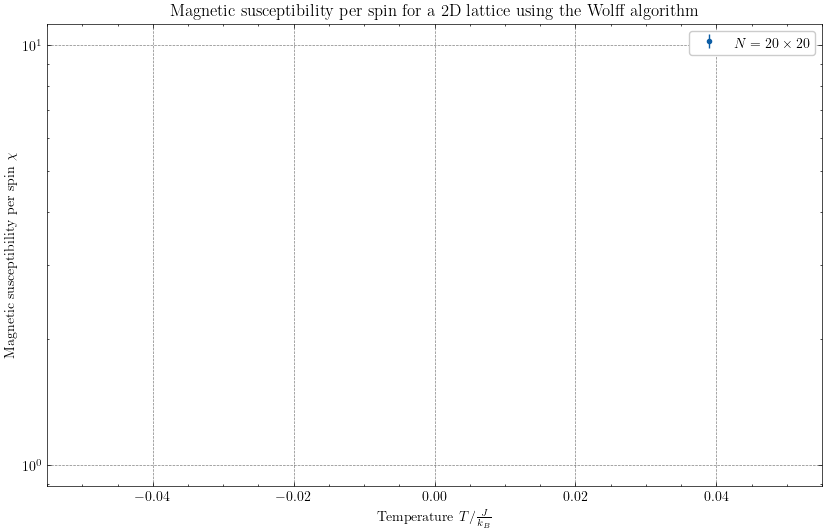

In [66]:
fig, ax = plot_observable_per_spin(con, simulation_id, Algorithm.Wolff, Observable.MagneticSusceptibility)
ax.set_yscale('log')
fig.savefig('figures/Wolff/MagneticSusceptibility.pdf', dpi=dpi,  bbox_inches='tight')

# Critical temperature

KeyError: 'slope'

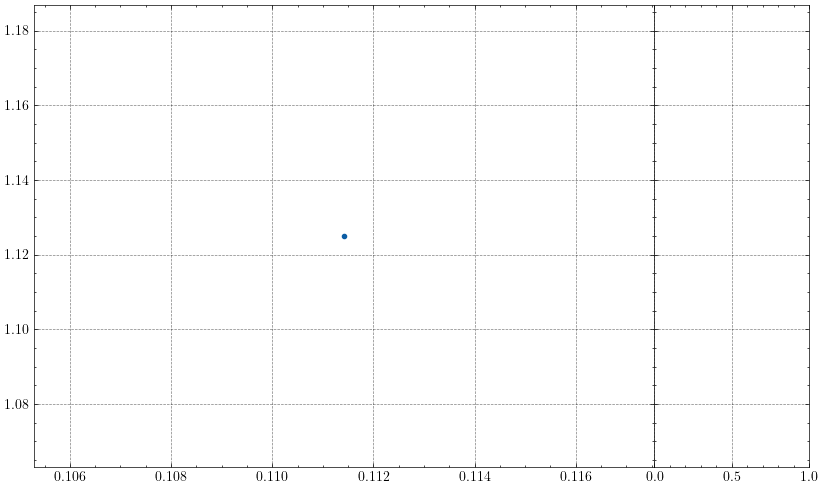

In [67]:
sampling = pd.Series(np.linspace(0, 0.25, num=100))

data = get_observable_max(con, simulation_id, Algorithm.Metropolis, Observable.MagneticSusceptibility)
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x)**2)

# PLOT DATA POINTS
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0, 'hspace': 0}, sharey='row', sharex='col')
ax[0].errorbar(data['size'], data['temperature'], label=f'Temperature $T$ at $\\chi_\\text{{max}}$')

# BOOTSTRAP INTERCEPT
boot = pd.DataFrame()
for i in range(10_000):
    draw = data.sample(len(data), replace=True)
    sizes = draw['size'].to_numpy()

    if not (sizes[0] == sizes).all():
        res = linregress(draw['size'], draw['temperature'])

        new = pd.DataFrame({'slope': [res.slope], 'intercept': [res.intercept]})
        boot = pd.concat([boot, new])

# GETTING CUTOFFS FOR QUANTILE
slope_top_percentile = boot['slope'].quantile(0.95)
slope_bottom_percentile = boot['slope'].quantile(1.0 - 0.95)
intercept_top_percentile = boot['intercept'].quantile(0.95)
intercept_bottom_percentile = boot['intercept'].quantile(1.0 - 0.95)

# FILTER FOR QUANTILE
slope_quantile = boot[boot['slope'].ge(slope_bottom_percentile) & boot['slope'].le(slope_top_percentile)]
print(f'Bootstrap slope: {slope_quantile['slope'].mean():.4f} +- {slope_quantile['slope'].std():.4f}')

intercept_quantile = boot[boot['intercept'].ge(intercept_bottom_percentile) & boot['intercept'].le(intercept_top_percentile)]
print(f'Bootstrap intercept: {intercept_quantile['intercept'].mean():.4f} +- {intercept_quantile['intercept'].std():.4f}')

# GET CONFIDENCE INTERVAL FOR INTERCEPT
cross = intercept_quantile.merge(sampling.rename('x'), how='cross')
cross['y'] = cross.apply(lambda x: x['x'] * x['slope'] + x['intercept'], axis=1)

ymax = cross.groupby('x')['y'].max()
ymin = cross.groupby('x')['y'].min()

# PLOT REGRESSION
res = linregress(data['size'], data['temperature'])
print(f'Linear slope: {res.slope:.4f} +- {intercept_quantile['slope'].std():.4f}')
print(f'Linear intercept: {res.intercept:.4f} +- {intercept_quantile['intercept'].std():.4f}')

ax[0].plot(sampling, sampling * res.slope + res.intercept, 'b-', label=f'Fit: $({res.slope:.2f} \\pm {slope_quantile['slope'].std():.2f}) \\cdot x + ({res.intercept:.4f} \\pm {intercept_quantile['intercept'].std():.4f})$')
ax[0].fill_between(sampling, ymin, ymax, alpha=0.2, label=f'Intercept $0.95$ quantile band')

ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()

# PLOT CENTRAL LIMIT THEOREM
ax[1].hist(boot['intercept'], bins=50, orientation='horizontal')
ax[1].axhline(intercept_quantile['intercept'].mean(), color='red', label=f'Mean {intercept_quantile['intercept'].mean():.4f}')
ax[1].axhspan(intercept_bottom_percentile, intercept_top_percentile, alpha=0.2, label=f'$0.95$ Quantile')

ax[1].set_title('Distribution of $b$')
ax[1].set_xlabel('Frequency')
ax[1].legend()

fig.savefig('figures/Metropolis/Critical_Temperature.pdf', dpi=dpi,  bbox_inches='tight')

Bootstrap slope: 2.3430 +- 0.4572
Bootstrap intercept: 0.8903 +- 0.0240
Linear slope: 2.0993 +- 0.4588
Linear intercept: 0.9028 +- 0.0240


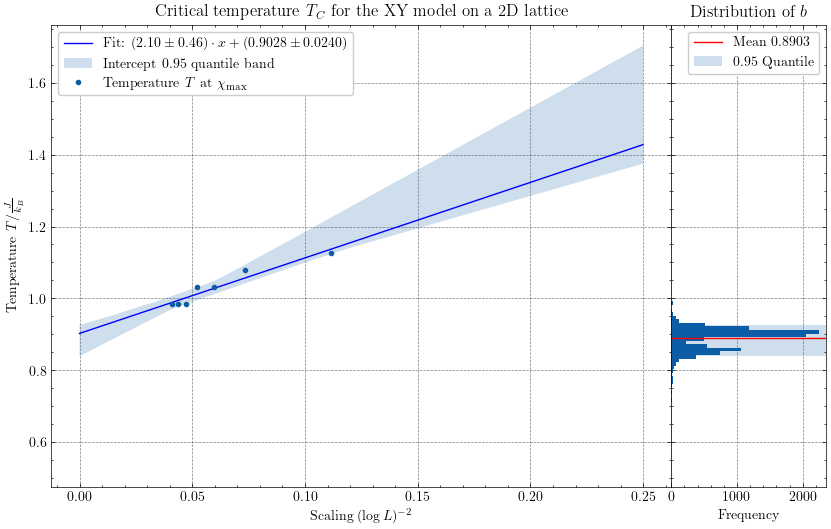

In [ ]:
sampling = pd.Series(np.linspace(0, 0.25, num=100))

data = get_observable_max(con, simulation_id, Algorithm.Wolff, Observable.MagneticSusceptibility)
data['size'] = data['lattice_size'].transform(lambda x: 1.0 / np.log(x)**2)

# PLOT DATA POINTS
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1], 'wspace': 0, 'hspace': 0}, sharey='row', sharex='col')
ax[0].errorbar(data['size'], data['temperature'], label=f'Temperature $T$ at $\\chi_\\text{{max}}$')

# BOOTSTRAP INTERCEPT
boot = pd.DataFrame()
for i in range(10_000):
    draw = data.sample(len(data), replace=True)
    sizes = draw['size'].to_numpy()

    if not (sizes[0] == sizes).all():
        res = linregress(draw['size'], draw['temperature'])

        new = pd.DataFrame({'slope': [res.slope], 'intercept': [res.intercept]})
        boot = pd.concat([boot, new])

# GETTING CUTOFFS FOR QUANTILE
slope_top_percentile = boot['slope'].quantile(0.95)
slope_bottom_percentile = boot['slope'].quantile(1.0 - 0.95)
intercept_top_percentile = boot['intercept'].quantile(0.95)
intercept_bottom_percentile = boot['intercept'].quantile(1.0 - 0.95)

# FILTER FOR QUANTILE
slope_quantile = boot[boot['slope'].ge(slope_bottom_percentile) & boot['slope'].le(slope_top_percentile)]
print(f'Bootstrap slope: {slope_quantile['slope'].mean():.4f} +- {slope_quantile['slope'].std():.4f}')

intercept_quantile = boot[boot['intercept'].ge(intercept_bottom_percentile) & boot['intercept'].le(intercept_top_percentile)]
print(f'Bootstrap intercept: {intercept_quantile['intercept'].mean():.4f} +- {intercept_quantile['intercept'].std():.4f}')

# GET CONFIDENCE INTERVAL FOR INTERCEPT
cross = intercept_quantile.merge(sampling.rename('x'), how='cross')
cross['y'] = cross.apply(lambda x: x['x'] * x['slope'] + x['intercept'], axis=1)

ymax = cross.groupby('x')['y'].max()
ymin = cross.groupby('x')['y'].min()

# PLOT REGRESSION
res = linregress(data['size'], data['temperature'])
print(f'Linear slope: {res.slope:.4f} +- {intercept_quantile['slope'].std():.4f}')
print(f'Linear intercept: {res.intercept:.4f} +- {intercept_quantile['intercept'].std():.4f}')

ax[0].plot(sampling, sampling * res.slope + res.intercept, 'b-', label=f'Fit: $({res.slope:.2f} \\pm {slope_quantile['slope'].std():.2f}) \\cdot x + ({res.intercept:.4f} \\pm {intercept_quantile['intercept'].std():.4f})$')
ax[0].fill_between(sampling, ymin, ymax, alpha=0.2, label=f'Intercept $0.95$ quantile band')

ax[0].set_title('Critical temperature $T_C$ for the XY model on a 2D lattice')
ax[0].set_xlabel('Scaling $(\\log{L})^{-2}$')
ax[0].set_ylabel('Temperature $T / \\frac{J}{k_B}$')
ax[0].legend()

# PLOT CENTRAL LIMIT THEOREM
ax[1].hist(boot['intercept'], bins=50, orientation='horizontal')
ax[1].axhline(intercept_quantile['intercept'].mean(), color='red', label=f'Mean {intercept_quantile['intercept'].mean():.4f}')
ax[1].axhspan(intercept_bottom_percentile, intercept_top_percentile, alpha=0.2, label=f'$0.95$ Quantile')

ax[1].set_title('Distribution of $b$')
ax[1].set_xlabel('Frequency')
ax[1].legend()

fig.savefig('figures/Wolff/Critical_Temperature.pdf', dpi=dpi,  bbox_inches='tight')